# Corona

attacking real Na22 events 

to use:     
1) fetch my (github/abotas) icaro WalkthroughCorona    
2) fetch my IC-1 branch corona.     
3) source manage.sh work_in_blah_blah 3.6   
4) download pmap and dst file for a run    
5) make sure you have IC_DATA and ICARO in your path
6) run

In [1]:
%matplotlib inline

import os
import sys
import random
import tables as tb
import numpy  as np

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from   invisible_cities.database import load_db
from   invisible_cities.core.system_of_units_c import units
from invisible_cities.reco.pmaps_functions import load_pmaps, integrate_charge, plot_s2si_map, select_si_slice
from invisible_cities.reco.tbl_functions     import get_event_numbers_and_timestamps
from   invisible_cities.reco.xy_algorithms import barycenter, corona
sys.path.append('/Users/alej/Desktop/Valencia/nextic/ICARO')
from   icaro.core.kdst_functions import load_dst, event_rate, profile_and_fit, print_fit, chi2
from invisible_cities.core.core_functions import in_range

NSIPM = 1792

Load data files

In [2]:
run_number = 3755
sub_run    = '000'
ic_data = os.path.join(os.environ['IC_DATA'])
dst_path  = ic_data + 'LSC/kdst/{}/dst_{}.root.h5'.format(run_number, run_number)
pmap_path = ic_data + 'LSC/pmaps/{}/pmaps.gdcsnext.{}_{}.root.h5'.format(run_number, sub_run, run_number)

#### PMAP

In [3]:
S1s, S2s, S2Sis = load_pmaps(pmap_path)

#### DST events in PMAP (Na22 evt candidates) 

In [4]:
full = load_dst(dst_path)
with tb.open_file(pmap_path,'r') as pf:
    sev = pf.root.Run.events[ 0]['evt_number']
    fev = pf.root.Run.events[-1]['evt_number']
Nasr  = full[in_range(full.event, sev, fev+1)]

I am going to further refine my search for events by looking at events with only one S2, just to keep things extra simple.

In [5]:
Nasr    = Nasr[Nasr.nS2 == 1]
Na_evts = list(set(Nasr.event.values))
peak = 0 # only option after my cut
Nasr

,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
7,5,1.492859e+09,0,1,250.0,12.042480,107.016224,203225.0,14.419797,1491.020386,...,213887.500,5,10.662500,10.662500,-59.802319,-125.385545,138.916710,-2.015832,7.463869,6.045628
11,7,1.492859e+09,0,1,175.0,24.401394,127.215739,200100.0,29.661250,12374.963867,...,362262.500,34,162.162500,162.162500,100.444835,-65.748967,120.050370,-0.579587,14.660998,11.629659
12,8,1.492859e+09,0,1,200.0,21.922300,126.956455,200125.0,26.071875,15811.878906,...,358337.500,21,158.212500,158.212500,-14.360467,14.802176,20.623468,2.341049,9.644219,9.979357
19,12,1.492859e+09,0,1,150.0,55.906155,253.569603,205425.0,4.594375,1893.904053,...,204743.125,1,-0.681875,-0.681875,95.000000,-25.000000,98.234414,-0.257324,0.000000,0.000000
20,13,1.492859e+09,0,1,175.0,32.010750,167.363379,200075.0,27.756250,9530.148438,...,382912.500,28,182.837500,182.837500,39.075109,14.255405,41.594239,0.349817,12.458802,10.570880
21,14,1.492859e+09,0,1,200.0,27.735479,147.196115,200100.0,29.125000,12260.648438,...,353437.500,25,153.337500,153.337500,-65.434214,-6.147367,65.722344,-3.047920,10.194994,9.853805
24,16,1.492859e+09,0,1,200.0,27.986231,150.574639,200150.0,14.825125,16886.318359,...,344562.500,37,144.412500,144.412500,156.990667,18.253927,158.048332,0.115754,11.763478,12.187593
25,17,1.492859e+09,0,1,200.0,40.156105,205.470679,200100.0,37.156188,12128.112305,...,332037.500,45,131.937500,131.937500,77.420002,-15.559090,78.967981,-0.198328,18.126823,11.369114
26,18,1.492859e+09,0,1,150.0,24.165491,122.113641,200125.0,36.998937,9220.875000,...,408412.500,24,208.287500,208.287500,-70.329229,-1.177809,70.339091,-3.124847,11.441946,9.212716
31,21,1.492859e+09,0,1,175.0,23.476559,133.899878,200125.0,19.775000,8202.237305,...,369937.500,28,169.812500,169.812500,130.194225,9.692152,130.554487,0.074307,11.711307,10.523380


In [6]:
# load the SiPM (x,y) values
DataSensor = load_db.DataSiPM()
dxs = DataSensor.X.values
dys = DataSensor.Y.values

In [7]:
# A method in HitCollectionCity
def compute_xy_position(si, slice_no):
    si      = select_si_slice(si, slice_no)
    IDs, Qs = map(list, zip(*si.items()))
    
    xs, ys  = dxs[IDs], dys[IDs]
    return corona(xs, ys, Qs, rmax=rmax, T=T, msipm=msipm)

def plot_helper(si, slice_no):
    si      = select_si_slice(si, slice_no)
    IDs, Qs = map(list, zip(*si.items()))
    xs, ys  = dxs[IDs], dys[IDs]
    return xs, ys, Qs

# plot a 48x48 SiPM map
# -- carried over from NEW_kr_diff_mc_train.ipynb
def plot_test_slice(l_X,l_Y,l_Q):
    """
    Plots a SiPM map in the NEW Geometry
    """

    # set up the figure
    fig = plt.figure();
    ax1 = fig.add_subplot(111);
    fig.set_figheight(10.0)
    fig.set_figwidth(10.0)
    ax1.axis([-250, 250, -250, 250]);

    # plot the SiPM pattern
    for xx,yy,qq in zip(l_X,l_Y,l_Q):
        r = Ellipse(xy=(xx, yy), width=2., height=2.);
        r.set_facecolor('0');
        r.set_alpha(qq);
        ax1.add_artist(r);

    plt.xlabel("x (mm)")
    plt.ylabel("y (mm)")
    return ax1

### Pick an event from the list

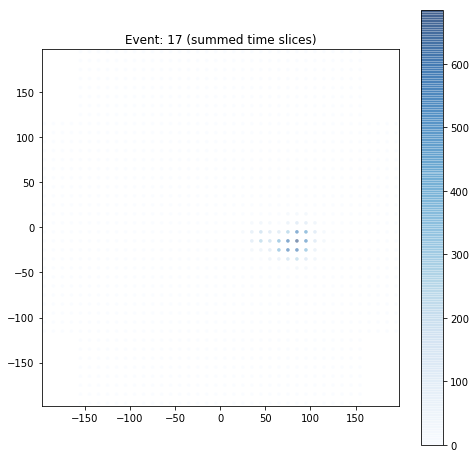

I picked a more interesting looking event


In [8]:
event_numbers, timestamps = get_event_numbers_and_timestamps(pmap_path)
event_number = Na_evts[7]
event_time   = timestamps[np.where(event_numbers==event_number)[0]]
plot_s2si_map(S2Sis[event_number])
plt.title('Event: ' + str(event_number) + ' (summed time slices)')
plt.show()
print('I picked a more interesting looking event')

#### Use corona (via compute_xy_position) to get the clusters for each slice

/Users/alej/miniconda/envs/IC3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


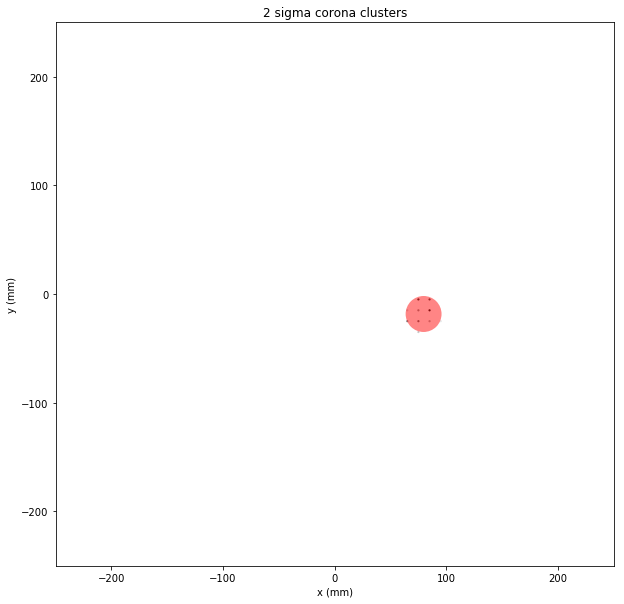

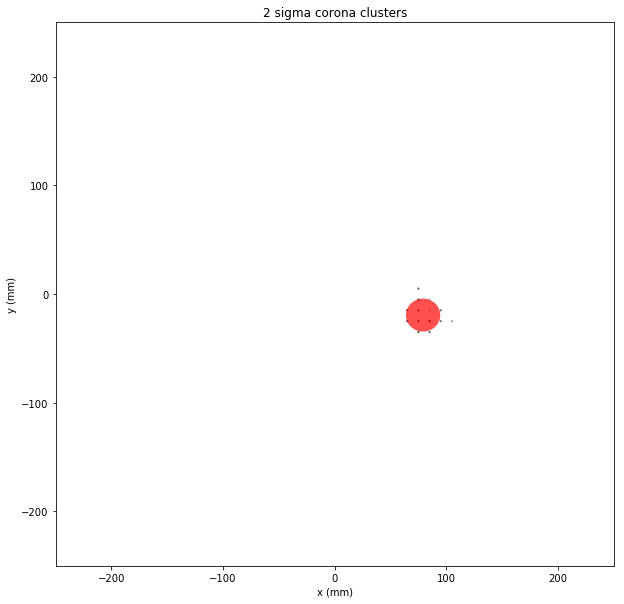

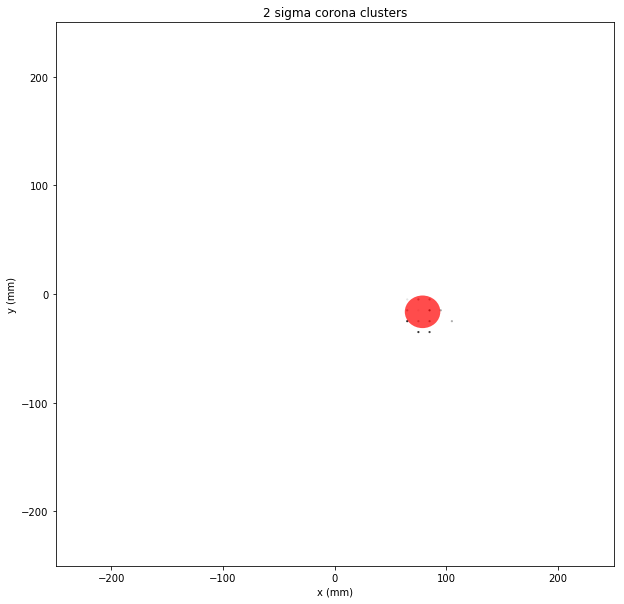

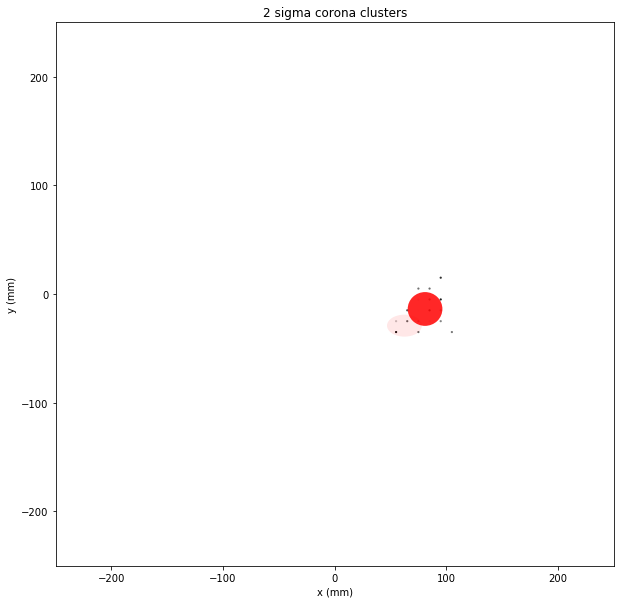

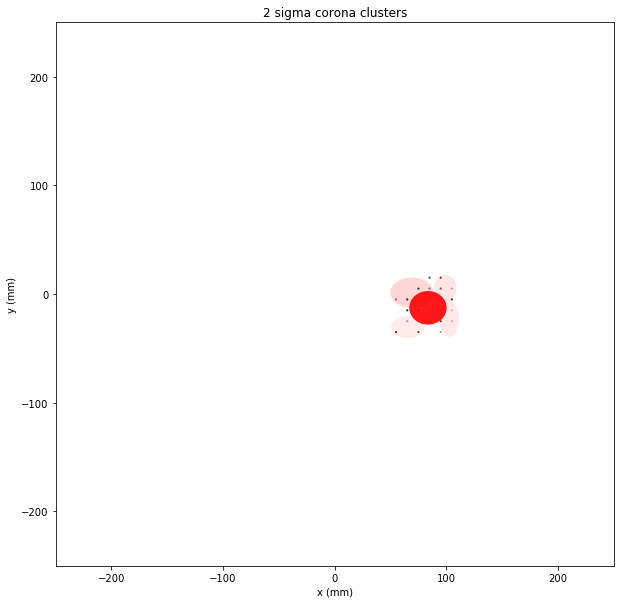

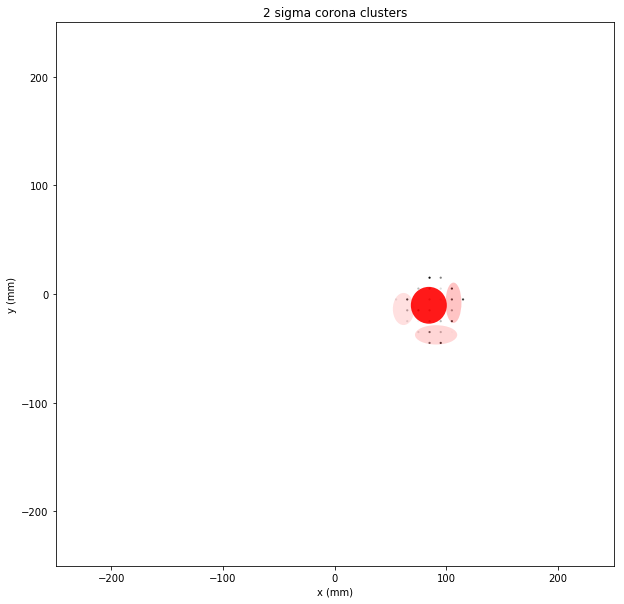

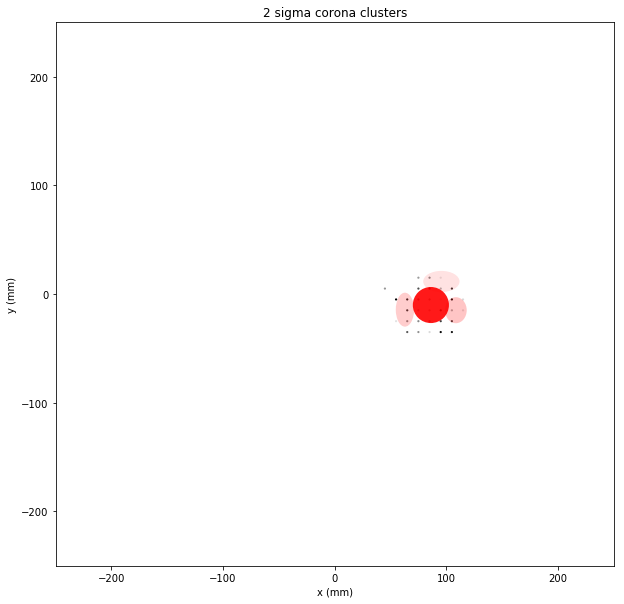

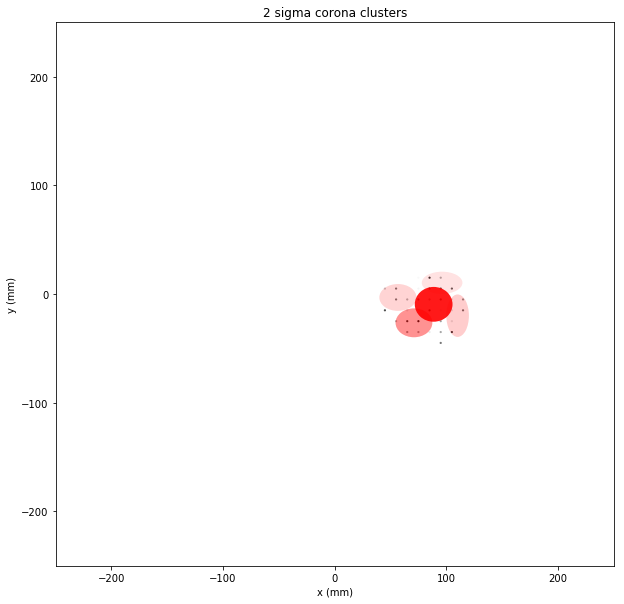

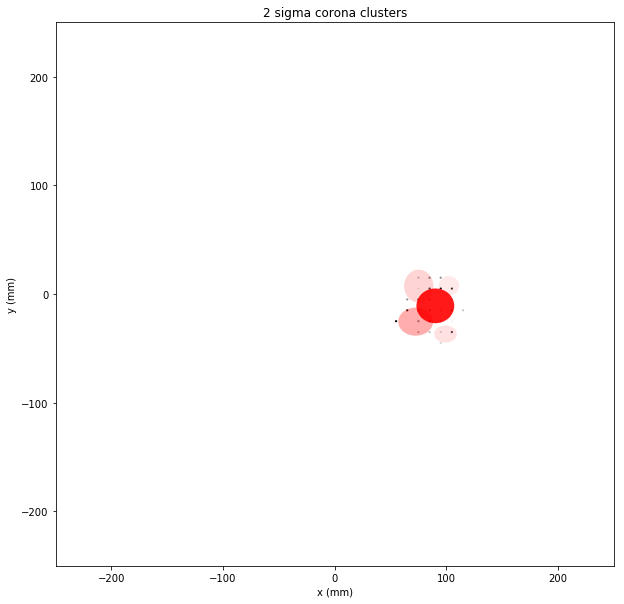

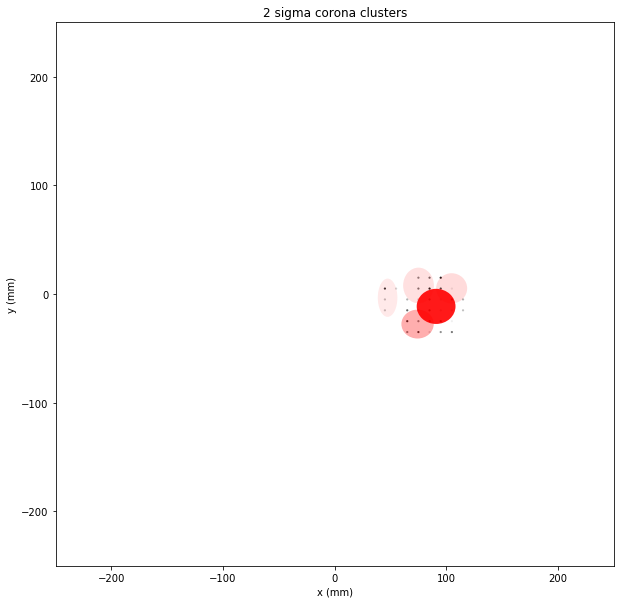

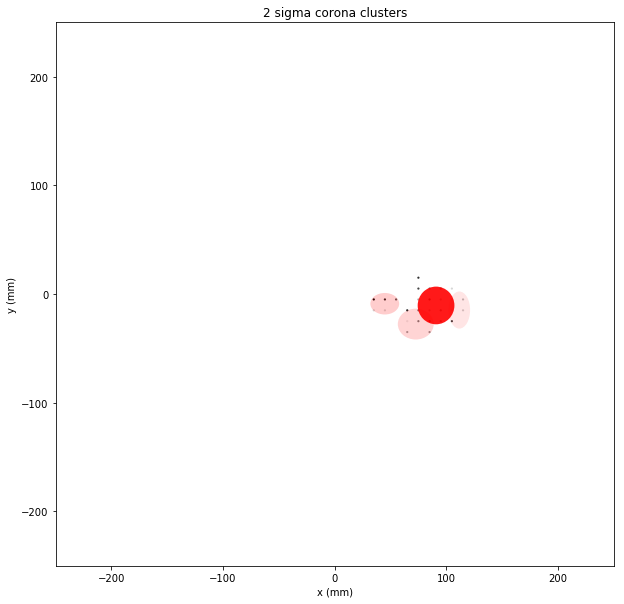

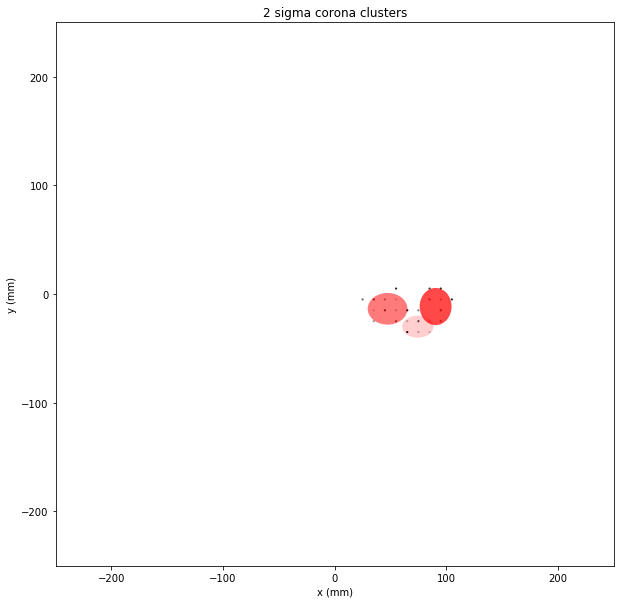

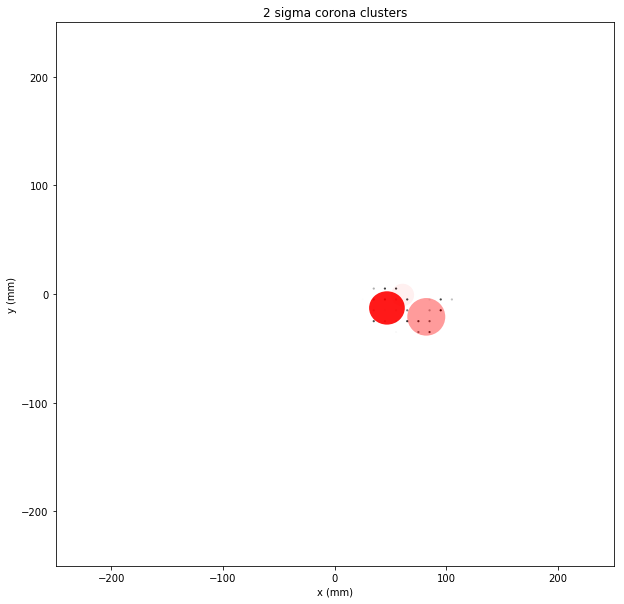

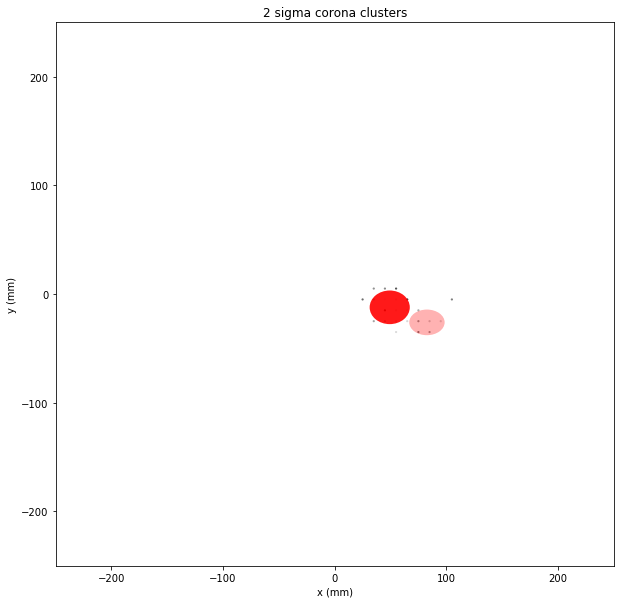

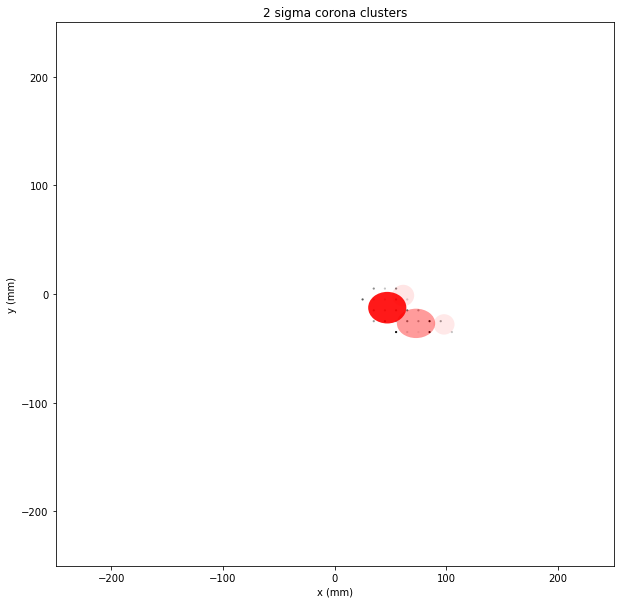

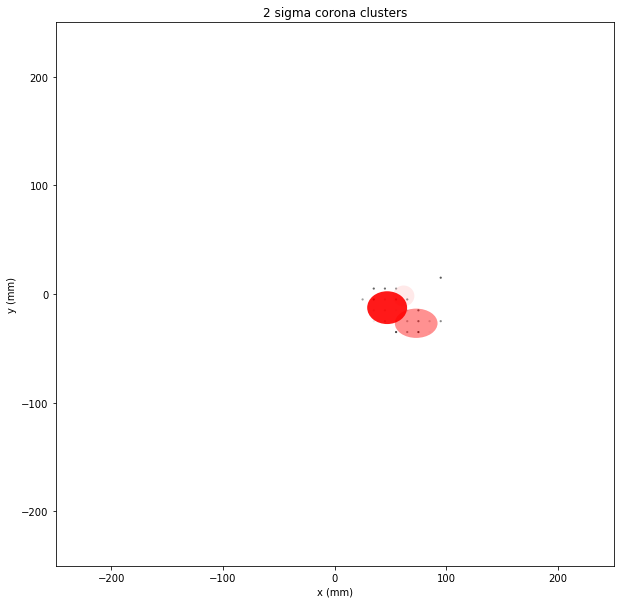

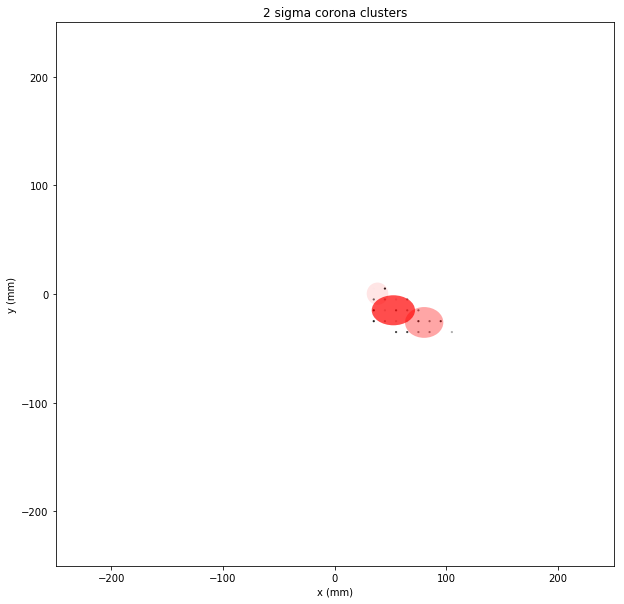

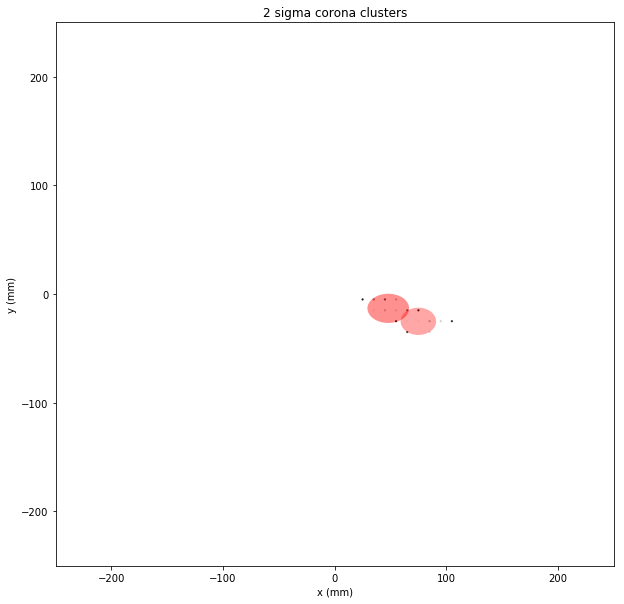

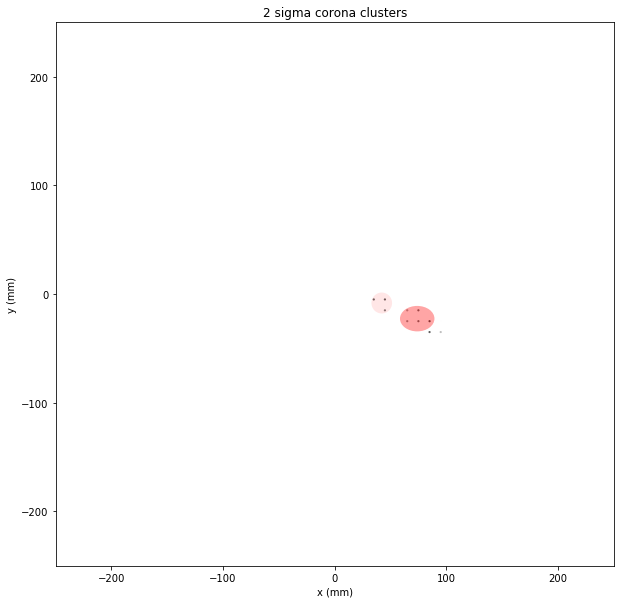

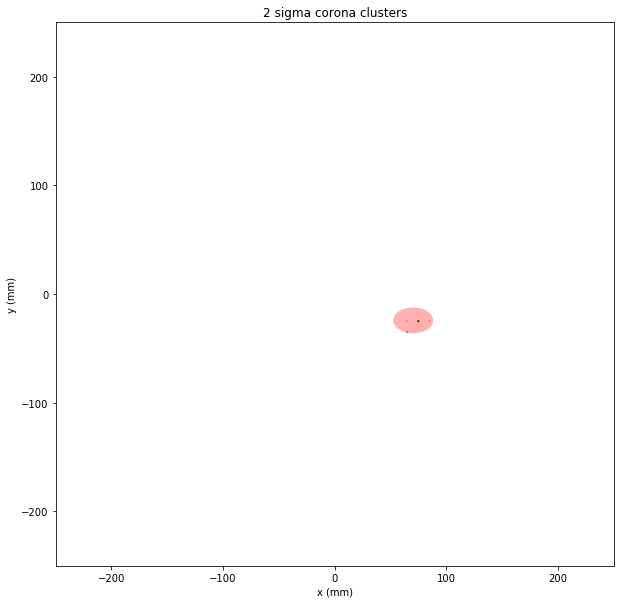

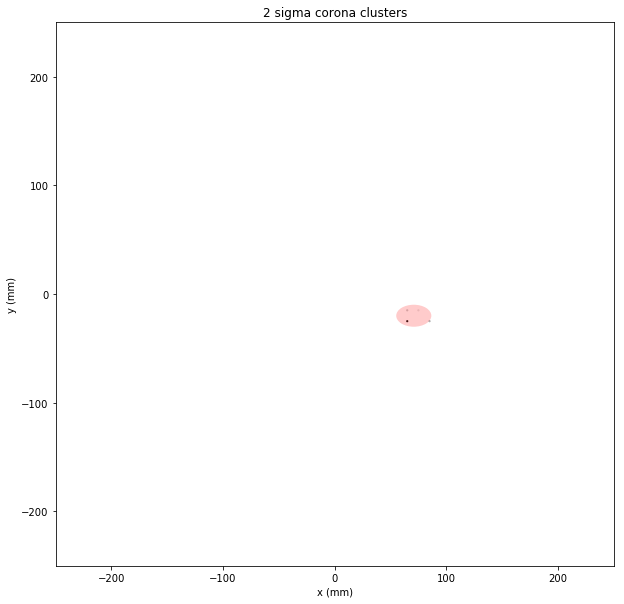

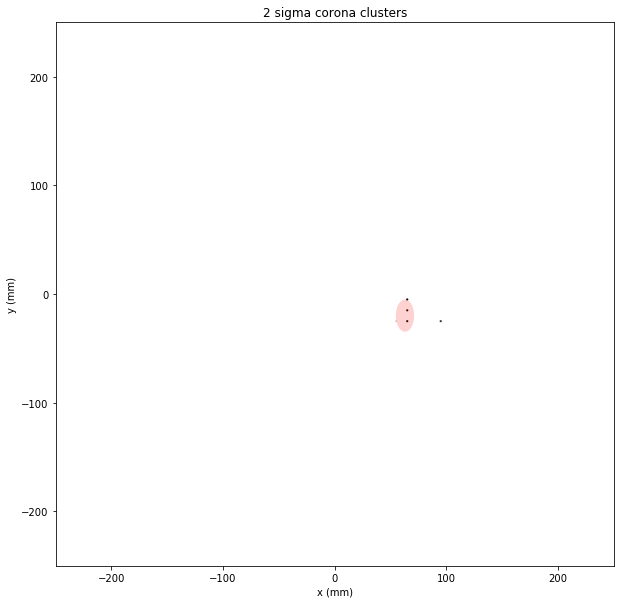

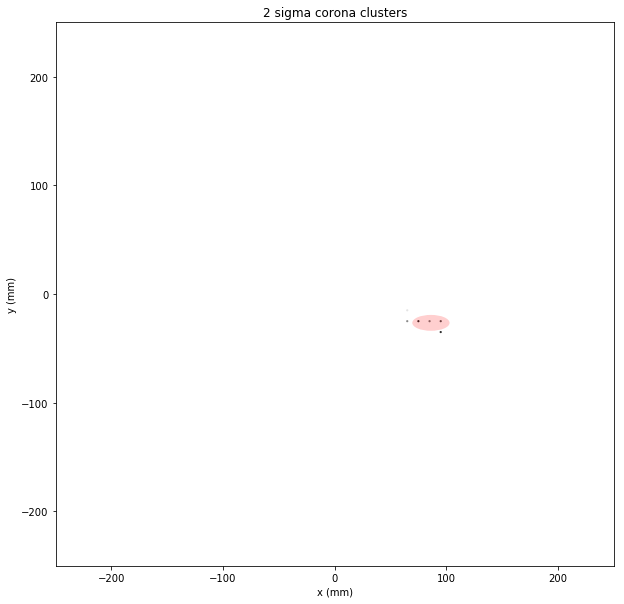

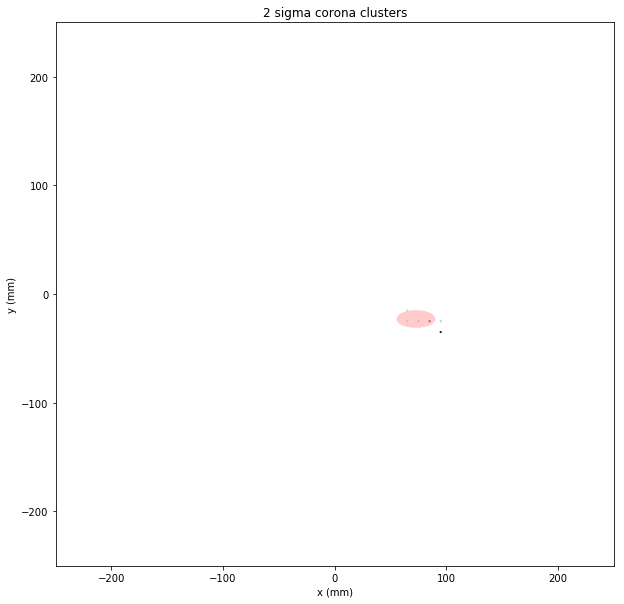

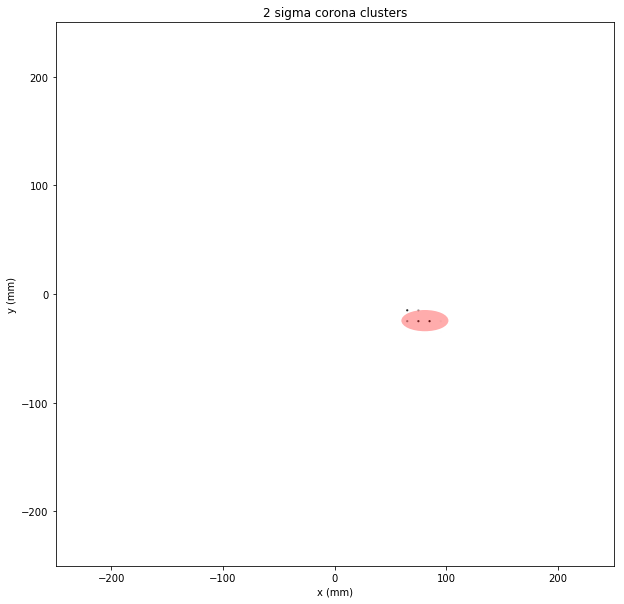

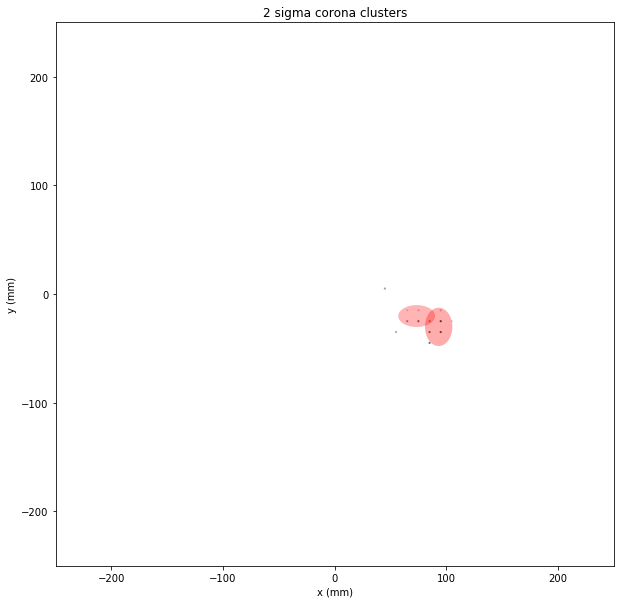

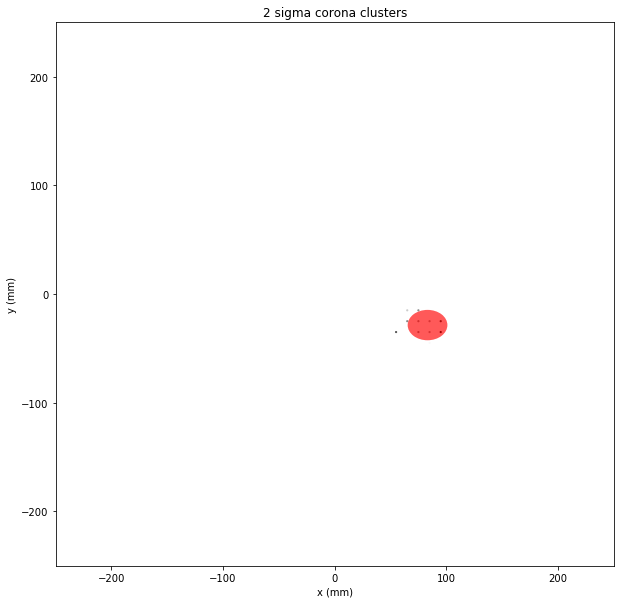

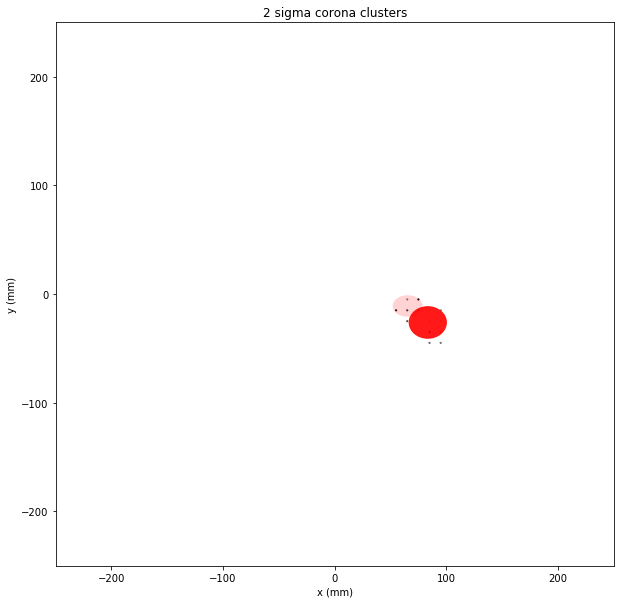

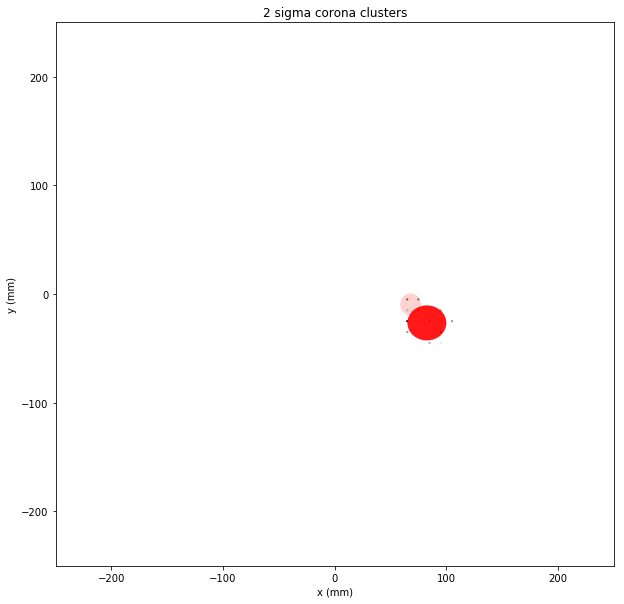

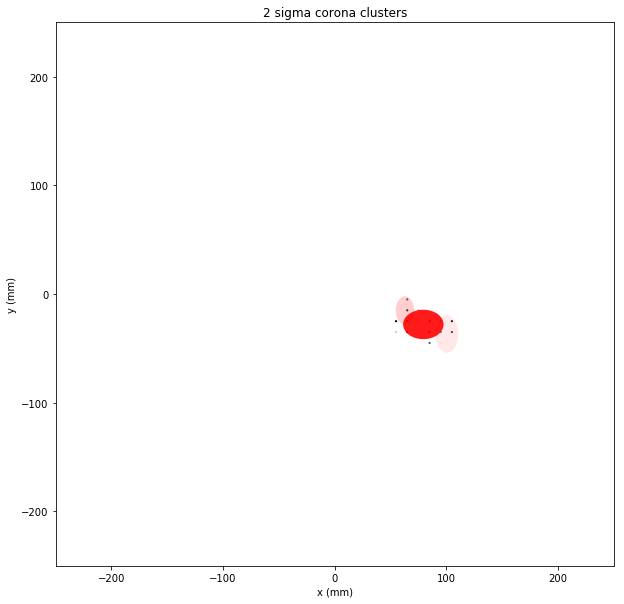

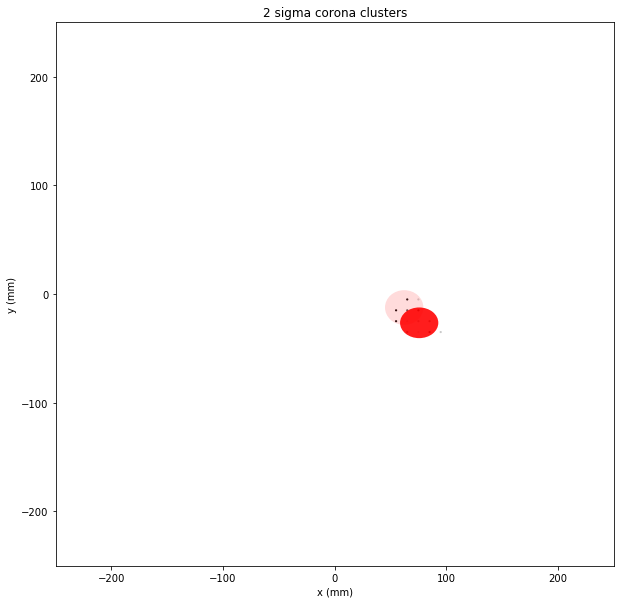

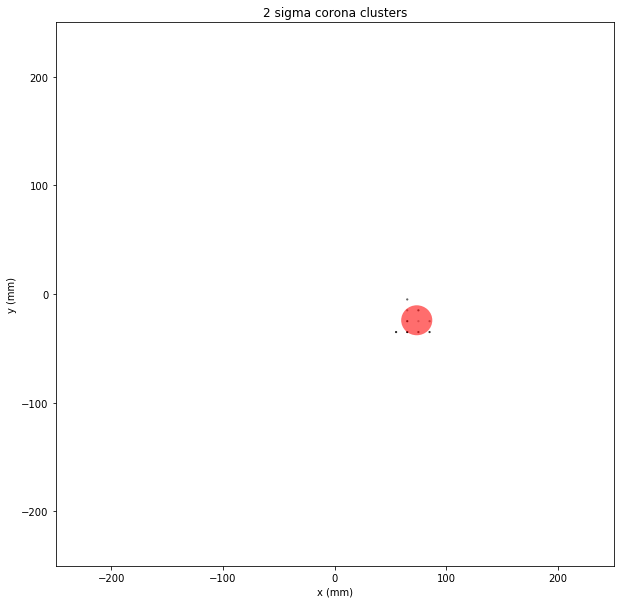

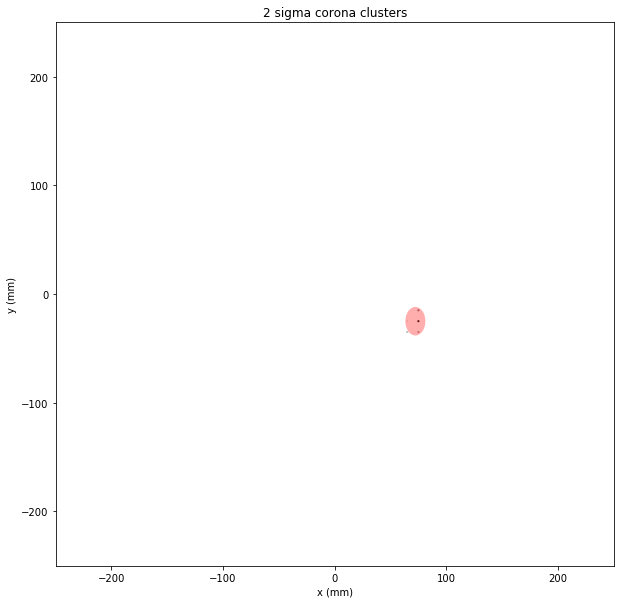

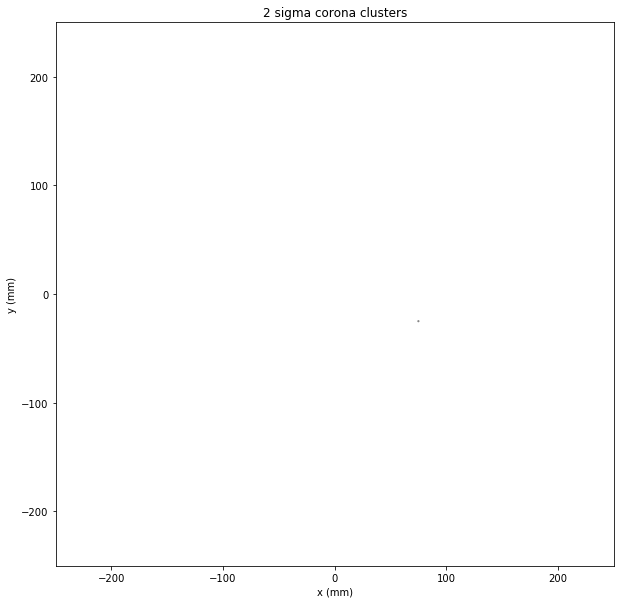

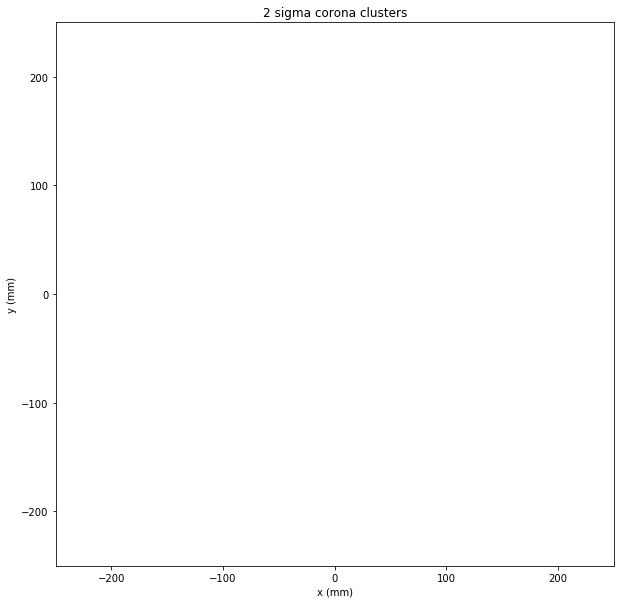

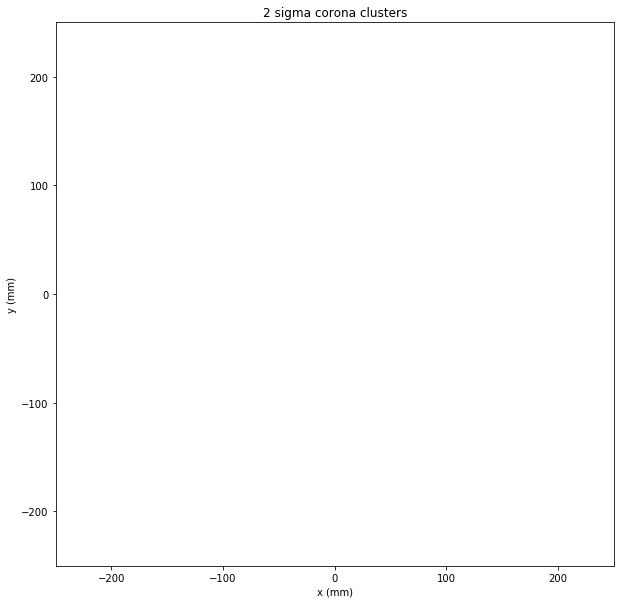

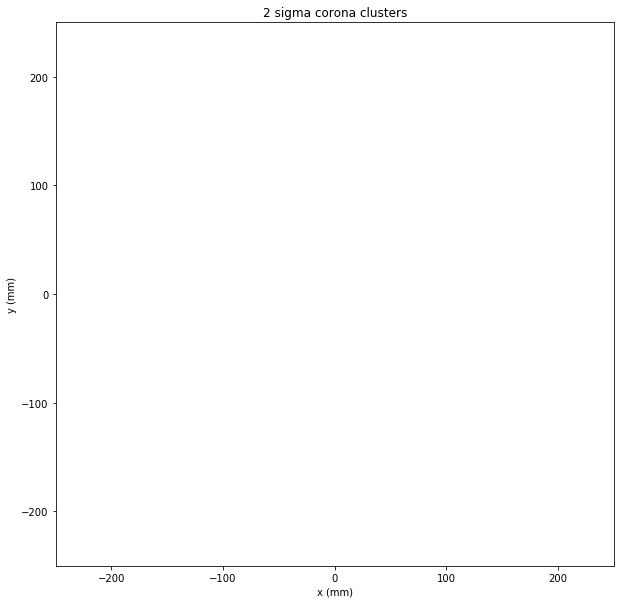

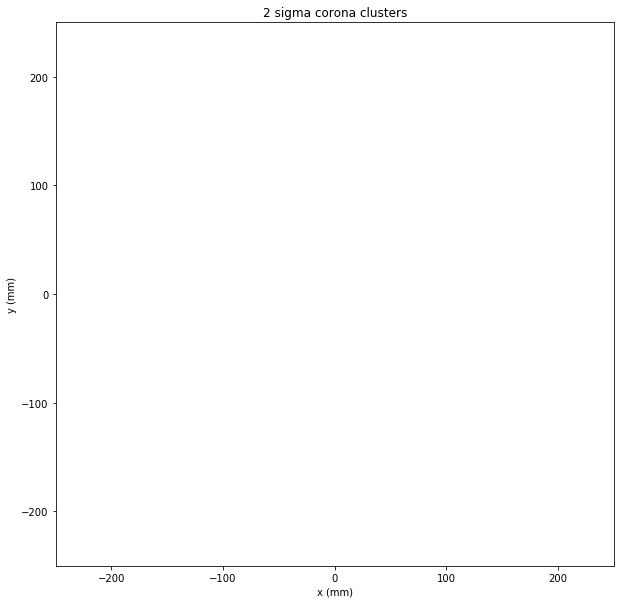

In [9]:
T     =  3*units.pes
msipm =  3
rmax  = 20*units.mm # if < 10mm won't see plots because xrms,yrms=0 sicne pitch=10mm
nsig  =  2 # plot param: ellipses with width 2*nsig*Xrms and height 2*nsig*Yrms

S1 = S1s  .get(event_number, {})
S2 = S2s  .get(event_number, {})
Si = S2Sis.get(event_number, {})
n_slices     = len(Si[peak][next(iter(Si[peak]))])

for slice_no in range(n_slices):
    clusters = compute_xy_position(Si[peak], slice_no)
    
    # Plot SiPMS
    ax = plot_test_slice(*plot_helper(Si[peak], slice_no))
    
    # Plot corona clusters
    for c in clusters: 
        e=Ellipse(xy=(c.X,c.Y), width=2*nsig*c.Xrms, height=2*nsig*c.Yrms)
        ax.add_artist(e)
        e.set_clip_box(ax.bbox)
        e.set_alpha(min(.90, c.Q / 200.0*units.pes))
        e.set_facecolor('red')

    plt.title(str(nsig) + ' sigma corona clusters')
    